In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)} 
s2i['.'] = 0

i2s = {i:s for s, i in s2i.items()}

In [7]:
# building the dataset
block_size = 3 #contenxt length

X, Y = [], []
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)

        #print(''.join(i2s[i] for i in context), '--->', i2s[ix])
        context = context[1:] + [ix]

In [8]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

#### Indexing and one-hot

In [12]:
C = torch.randn((27, 2)) #2 is the embedding size
C

tensor([[ 0.0073,  0.1379],
        [ 2.1015,  0.4133],
        [-1.3626, -0.1898],
        [-0.0450, -0.4940],
        [-1.9448, -0.9508],
        [ 0.2670, -0.4977],
        [-1.8959, -0.2677],
        [ 0.2495,  0.9664],
        [ 1.1502,  0.8616],
        [ 0.3758,  0.0618],
        [ 1.0374,  1.4334],
        [-0.2174, -1.0009],
        [-0.1946,  0.0951],
        [-0.3627, -3.4126],
        [-0.4749, -0.5984],
        [ 0.9920, -0.9968],
        [-1.6229,  2.5238],
        [-0.4535,  0.4953],
        [-1.0548, -0.3281],
        [ 0.8739,  0.3518],
        [ 0.3360,  1.1373],
        [-1.2395,  0.0562],
        [-1.1341,  0.1954],
        [ 2.0576, -0.5669],
        [ 1.0130,  0.4535],
        [ 1.8646, -0.8412],
        [ 0.5834,  0.2036]])

In [13]:
C.dtype

torch.float32

In [14]:
one_hot = F.one_hot(torch.tensor(5), num_classes=27).float()

In [15]:
C[5] == one_hot @ C

tensor([True, True])

In [16]:
print(C[5])
print(one_hot@C)

tensor([ 0.2670, -0.4977])
tensor([ 0.2670, -0.4977])


#### Pytorch indexing is powerful

In [17]:
X[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [18]:
C[X][1]

tensor([[ 0.0073,  0.1379],
        [ 0.0073,  0.1379],
        [ 0.2670, -0.4977]])

In [19]:
C.shape

torch.Size([27, 2])

In [15]:
C[[0,0,5]]

tensor([[ 0.1451, -1.1736],
        [ 0.1451, -1.1736],
        [ 0.0055,  1.5480]])

In [16]:
C[X].shape

torch.Size([228146, 3, 2])

In [17]:
C[X][:2]

tensor([[[ 0.1451, -1.1736],
         [ 0.1451, -1.1736],
         [ 0.1451, -1.1736]],

        [[ 0.1451, -1.1736],
         [ 0.1451, -1.1736],
         [ 0.0055,  1.5480]]])

In [18]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [26]:
W1 = torch.randn((6, 100)) # 100 is the number of hidden units
b1 = torch.randn(100)

In [19]:
# need to concatenate the embedding!
emb[:, 0, :].shape

torch.Size([228146, 2])

In [20]:
# we need to cancatenate along the three dimensions
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [21]:
# need to generalize!
torch.cat(torch.unbind(emb, 1), 1).shape # same as the above but we did'n explicitely list the context (that depends on the block size)

torch.Size([228146, 6])

In [24]:
# using pytorch's view as a more efficient way (and faster) to concatenate
emb.view(-1,6).shape
(emb.view(-1, 6) == torch.cat(torch.unbind(emb, 1), 1))[0,0].item()

True

In [27]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [28]:
h.shape

torch.Size([228146, 100])

In [29]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [30]:
logits = h @ W2 + b2

In [31]:
counts = logits.exp()

In [32]:
p = counts/counts.sum(1, keepdim=True)

In [33]:
p.shape

torch.Size([228146, 27])

In [34]:
p[0].sum() == 1

tensor(True)

In [35]:
loss = -p[torch.arange(p.shape[0]), Y].log().mean()
loss

tensor(13.7602)

### Wrapping everything

In [107]:
# parameters initialization
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
sum(p.nelement() for p in parameters)

3481

In [109]:
for p in parameters:
    p.requires_grad = True

In [110]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

18.41695213317871


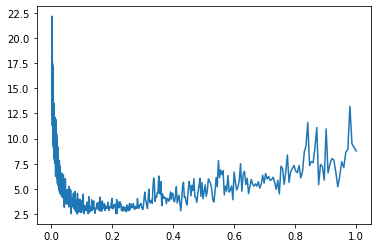

In [111]:
lri = []
lossi = []

# forward pass
for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))


    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32 x 100
    logits = h @ W2 + b2 #32 x 27
    loss = F.cross_entropy(logits, Y[ix])
    if i % 1000 == 0:
        print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lrs[i] * p.grad
    
    lri.append(lrs[i])
    lossi.append(loss.item())

plt.plot(lri, lossi)

In [112]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32 x 100
logits = h @ W2 + b2 #32 x 27
loss = F.cross_entropy(logits, Y)
loss

tensor(9.2998, grad_fn=<NllLossBackward0>)